In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset

In [3]:
print("Loading datasets...")
train_df = pd.read_csv('data/train.csv')
valid_df = pd.read_csv('data/valid.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {valid_df.shape}")
print(f"Test data shape: {test_df.shape}")

Loading datasets...
Train data shape: (500, 3)
Validation data shape: (100, 3)
Test data shape: (400, 3)


In [4]:
print("\nSample train data:")
print(train_df.head())

print("\nLabel distribution in train data:")
print(train_df['label'].value_counts())


Sample train data:
    id                                               text     label
0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
2  436               Ibu pernah bekerja di grab indonesia   neutral
3  394  Paling suka banget makan siang di sini ayam sa...  positive
4  592                    Pelayanan bus DAMRI sangat baik  positive

Label distribution in train data:
negative    192
positive    189
neutral     119
Name: label, dtype: int64


## Text Preprocessing

In [5]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 128

In [6]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    output_mode='int'
)
text_vectorizer.adapt(train_df['text'].values)

In [7]:
X_train = text_vectorizer(train_df['text'].values).numpy()
X_valid = text_vectorizer(valid_df['text'].values).numpy()
X_test = text_vectorizer(test_df['text'].values).numpy()

In [8]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_valid = label_encoder.transform(valid_df['label'])
y_test = label_encoder.transform(test_df['label'])

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Number of classes: 3
Classes: ['negative' 'neutral' 'positive']
X_train shape: (500, 100)
y_train shape: (500,)


## Model Building Functions

In [9]:
def create_rnn_model(num_layers=1, units_per_layer=64, bidirectional=False, vocab_size=MAX_VOCAB_SIZE, 
                     embedding_dim=EMBEDDING_DIM, max_length=MAX_SEQUENCE_LENGTH, num_classes=num_classes):

    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    
    # RNN layers
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1) 
        
        if bidirectional:
            model.add(Bidirectional(SimpleRNN(units_per_layer, return_sequences=return_sequences)))
        else:
            model.add(SimpleRNN(units_per_layer, return_sequences=return_sequences))
        
        # Add dropout after each RNN layer
        model.add(Dropout(0.3))
    
    # Dense output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [10]:
def train_model(model, X_train, y_train, X_valid, y_valid, epochs=20, batch_size=32):

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    return history

In [11]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
    
    return macro_f1, y_pred_classes

In [12]:
def plot_training_history(histories, labels, title):

    plt.figure(figsize=(20, 15))
    
    # Training Loss
    plt.subplot(2, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label}', linewidth=2)
    plt.title(f'{title} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation Loss
    plt.subplot(2, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label}', linewidth=2, linestyle='--')
    plt.title(f'{title} - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Training Accuracy
    plt.subplot(2, 2, 3)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label}', linewidth=2)
    plt.title(f'{title} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation Accuracy
    plt.subplot(2, 2, 4)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label}', linewidth=2, linestyle='--')
    plt.title(f'{title} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Experiment

## Experiment 1: Pengaruh Jumlah Layer RNN


Training model with 1 RNN layer(s)...
Model summary for 1 layer(s):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 1,292,547
Trainable params: 1,292,547
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
16/16 [==============================] - 1s 39ms/step - loss: 1.0965 - accuracy: 0.3600 - val_loss

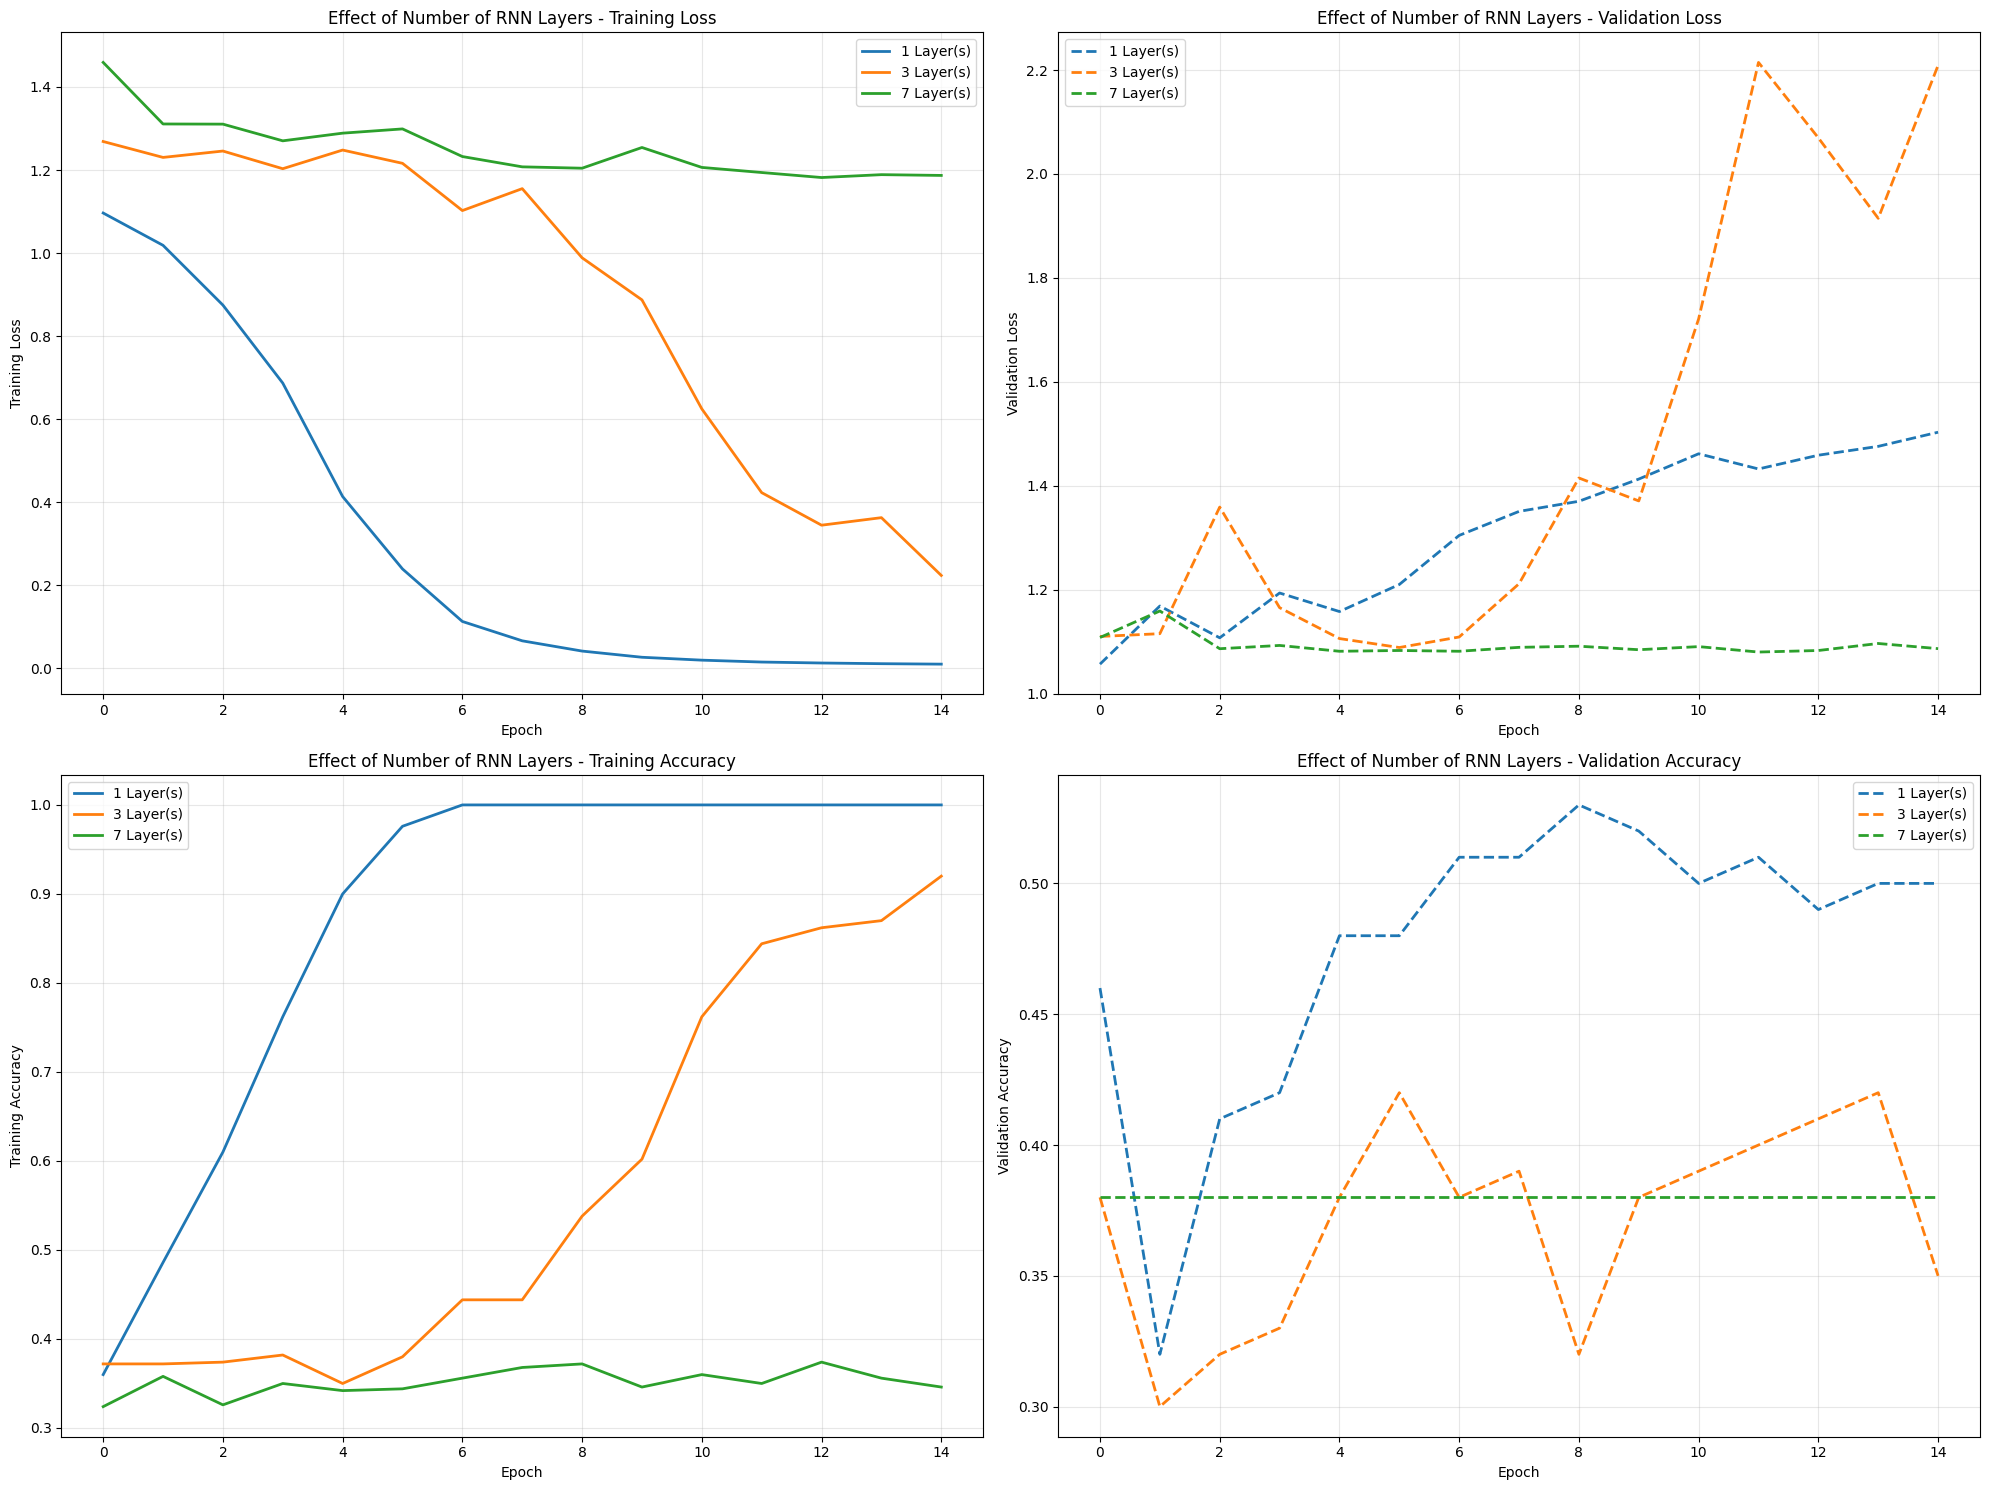

1 Layer(s): Macro F1-Score = 0.4092
3 Layer(s): Macro F1-Score = 0.3571
7 Layer(s): Macro F1-Score = 0.1827


In [13]:
layer_variations = [1, 3, 7]
layer_results = {}
layer_histories = []
layer_labels = []

for num_layers in layer_variations:
    print(f"\nTraining model with {num_layers} RNN layer(s)...")
    
    model = create_rnn_model(num_layers=num_layers, units_per_layer=64)
    print(f"Model summary for {num_layers} layer(s):")
    model.summary()
    

    history = train_model(model, X_train, y_train, X_valid, y_valid, epochs=15)
    macro_f1, y_pred = evaluate_model(model, X_test, y_test)

    layer_results[num_layers] = {
        'model': model,
        'history': history,
        'macro_f1': macro_f1,
        'predictions': y_pred
    }
    
    layer_histories.append(history)
    layer_labels.append(f'{num_layers} Layer(s)')
    
    print(f"Macro F1-Score for {num_layers} layer(s): {macro_f1:.4f}")


plot_training_history(layer_histories, layer_labels, "Effect of Number of RNN Layers")
for num_layers in layer_variations:
    print(f"{num_layers} Layer(s): Macro F1-Score = {layer_results[num_layers]['macro_f1']:.4f}")

## Experiment 2: Pengaruh Banyak Cell RNN per Layer


Training model with 32 cells per layer...
Model summary for 32 cells:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 100, 32)           5152      
                                                                 
 dropout_11 (Dropout)        (None, 100, 32)           0         
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                 

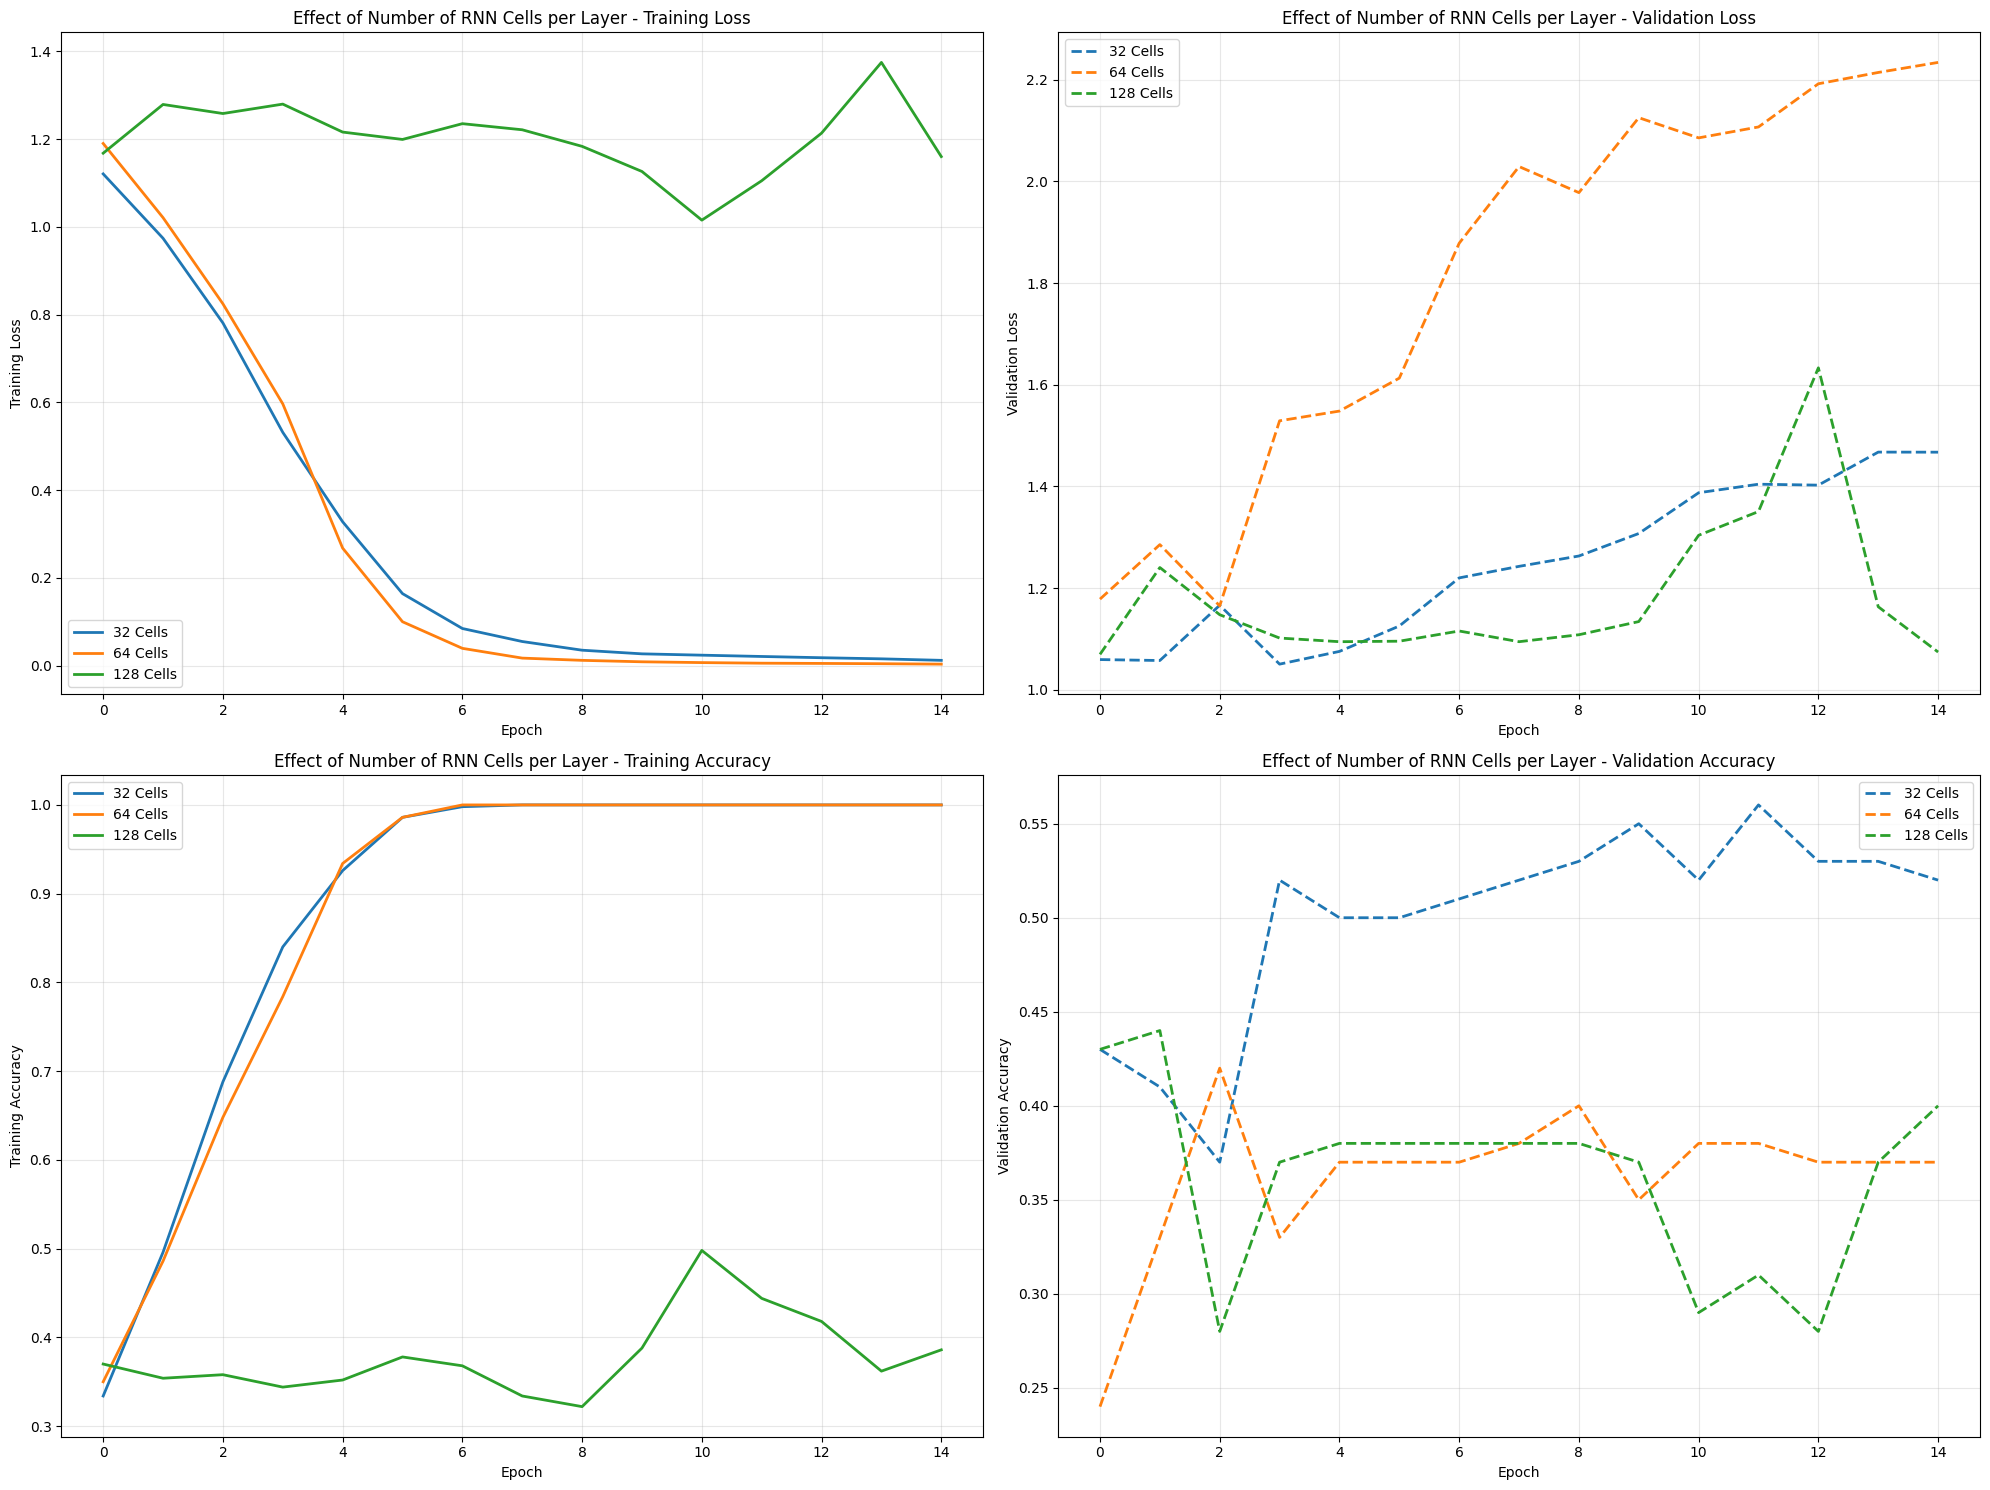

32 Cells: Macro F1-Score = 0.4937
64 Cells: Macro F1-Score = 0.4614
128 Cells: Macro F1-Score = 0.2657


In [14]:
cell_variations = [32, 64, 128]
cell_results = {}
cell_histories = []
cell_labels = []

for num_cells in cell_variations:
    print(f"\nTraining model with {num_cells} cells per layer...")

    model = create_rnn_model(num_layers=2, units_per_layer=num_cells)
    print(f"Model summary for {num_cells} cells:")
    model.summary()
    
    history = train_model(model, X_train, y_train, X_valid, y_valid, epochs=15)
    macro_f1, y_pred = evaluate_model(model, X_test, y_test)

    cell_results[num_cells] = {
        'model': model,
        'history': history,
        'macro_f1': macro_f1,
        'predictions': y_pred
    }
    
    cell_histories.append(history)
    cell_labels.append(f'{num_cells} Cells')
    
    print(f"Macro F1-Score for {num_cells} cells: {macro_f1:.4f}")

plot_training_history(cell_histories, cell_labels, "Effect of Number of RNN Cells per Layer")
for num_cells in cell_variations:
    print(f"{num_cells} Cells: Macro F1-Score = {cell_results[num_cells]['macro_f1']:.4f}")

## Experiment 3: Pengaruh Jenis Layer RNN Berdasarkan Arah


Training Unidirectional RNN model...
Model summary for Unidirectional RNN:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 100, 64)           12352     
                                                                 
 dropout_17 (Dropout)        (None, 100, 64)           0         
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                            

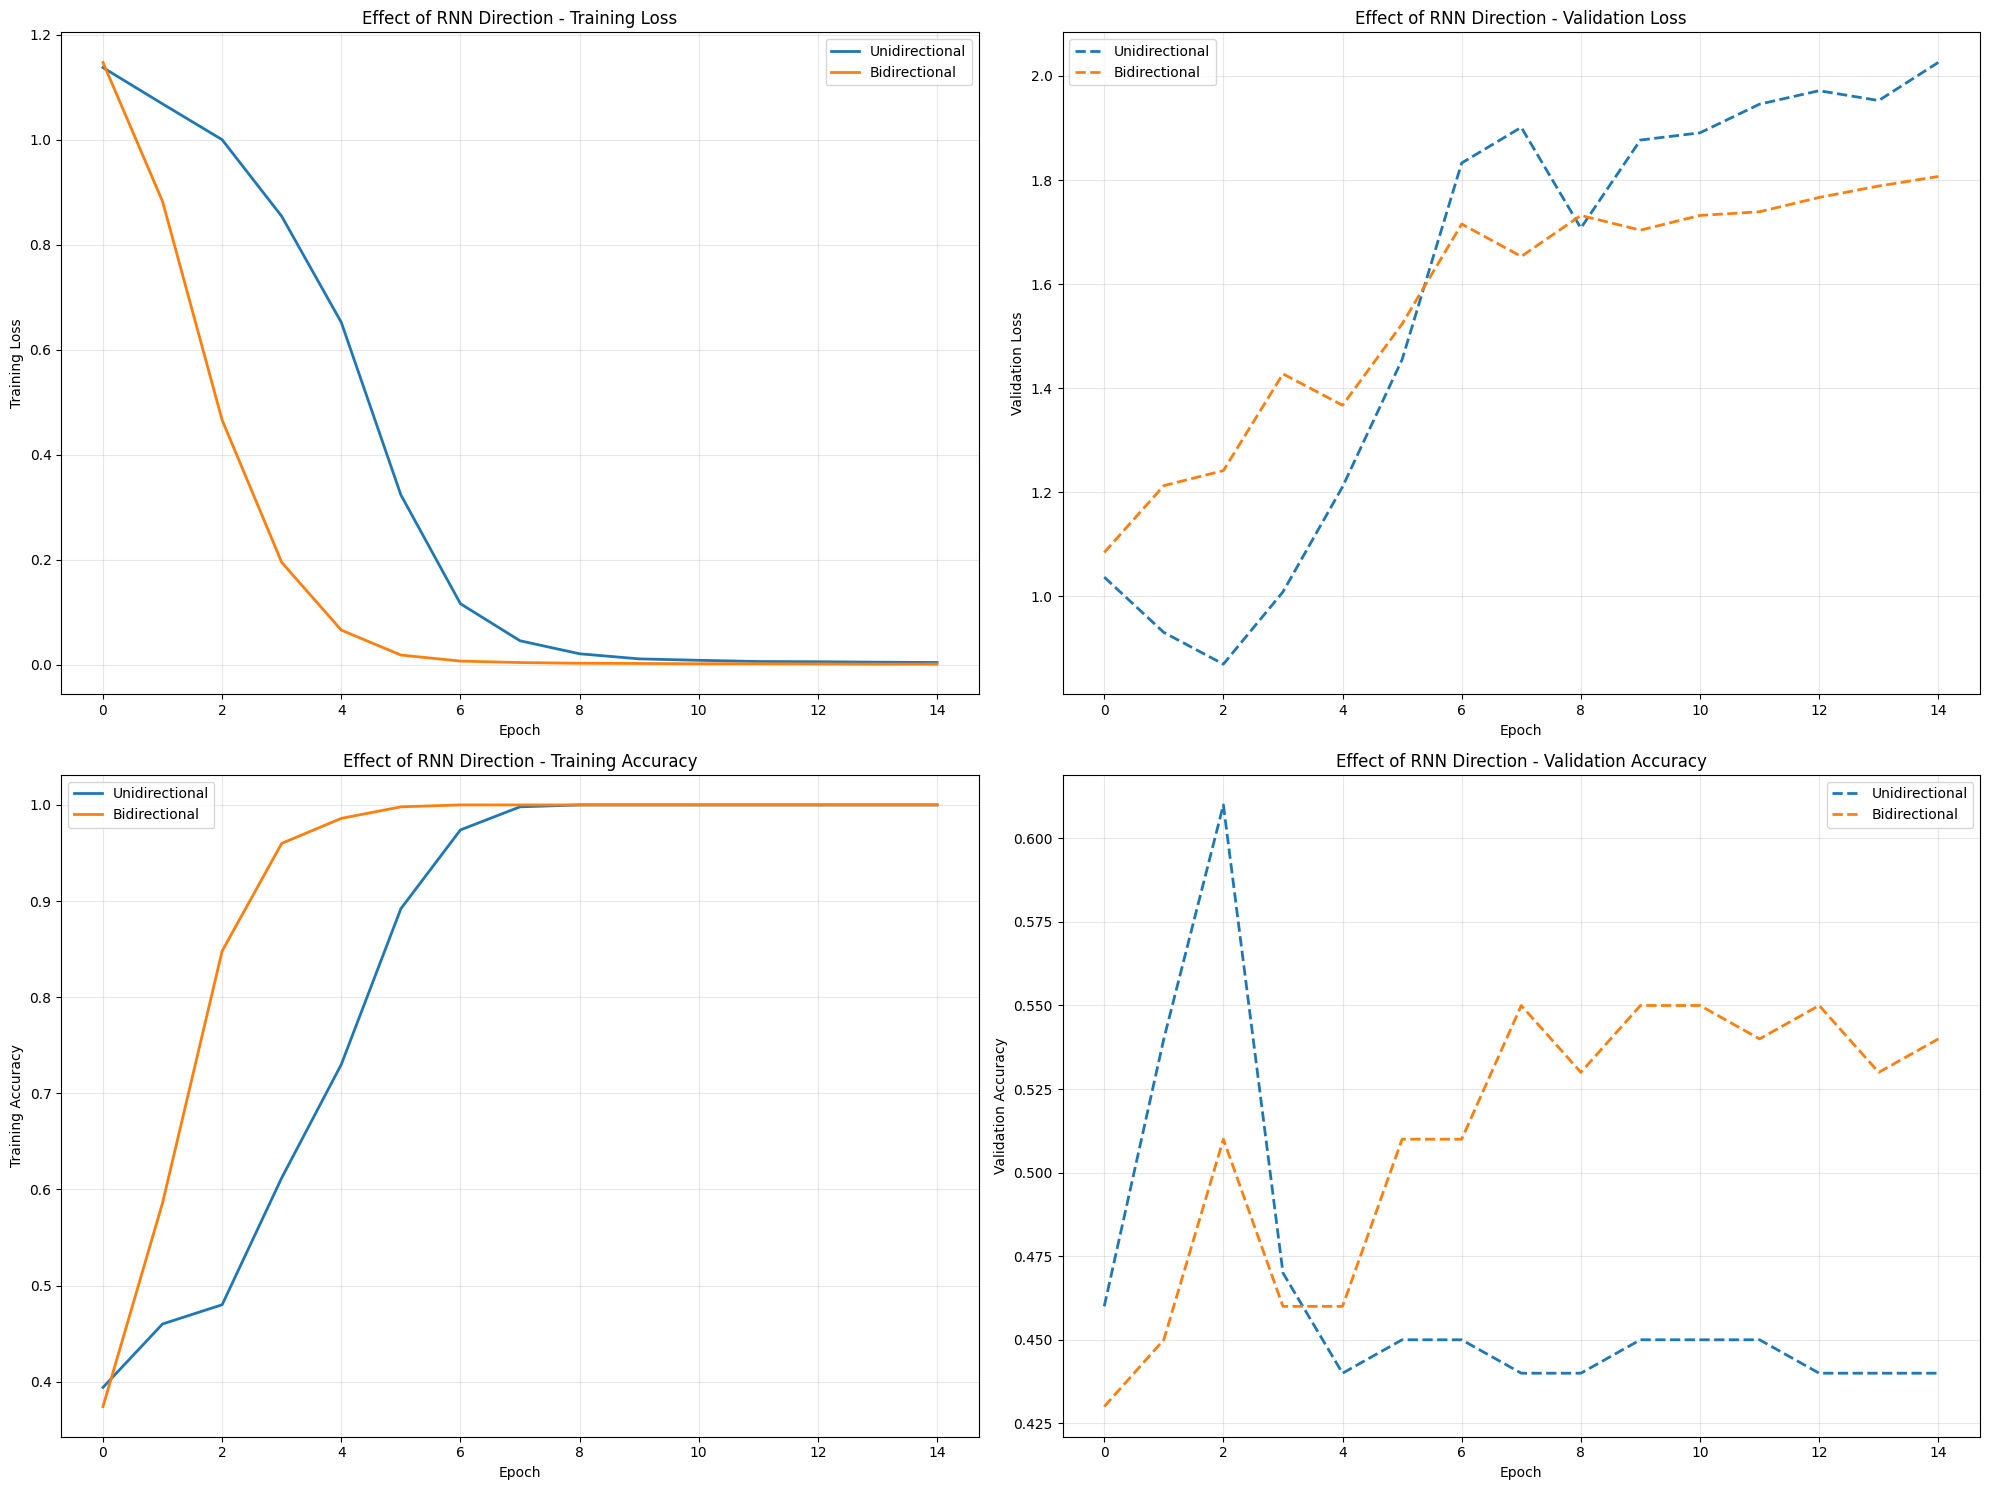

Unidirectional: Macro F1-Score = 0.4963
Bidirectional: Macro F1-Score = 0.5270


In [15]:
direction_variations = [False, True] 
direction_labels_map = {False: 'Unidirectional', True: 'Bidirectional'}
direction_results = {}
direction_histories = []
direction_labels = []

for bidirectional in direction_variations:
    direction_name = direction_labels_map[bidirectional]
    print(f"\nTraining {direction_name} RNN model...")
    
    model = create_rnn_model(num_layers=2, units_per_layer=64, bidirectional=bidirectional)
    print(f"Model summary for {direction_name} RNN:")
    model.summary()

    history = train_model(model, X_train, y_train, X_valid, y_valid, epochs=15)
    macro_f1, y_pred = evaluate_model(model, X_test, y_test)

    direction_results[bidirectional] = {
        'model': model,
        'history': history,
        'macro_f1': macro_f1,
        'predictions': y_pred
    }
    
    direction_histories.append(history)
    direction_labels.append(direction_name)
    
    print(f"Macro F1-Score for {direction_name}: {macro_f1:.4f}")

plot_training_history(direction_histories, direction_labels, "Effect of RNN Direction")
for bidirectional in direction_variations:
    direction_name = direction_labels_map[bidirectional]
    print(f"{direction_name}: Macro F1-Score = {direction_results[bidirectional]['macro_f1']:.4f}")

## Summary

In [16]:
print("\n1. PENGARUH JUMLAH LAYER RNN:")
best_layers = max(layer_results.keys(), key=lambda x: layer_results[x]['macro_f1'])
for num_layers in layer_variations:
    f1_score = layer_results[num_layers]['macro_f1']
    print(f"   {num_layers} Layer(s): {f1_score:.4f}" + (" -- BEST" if num_layers == best_layers else ""))

print("\n2. PENGARUH BANYAK CELL RNN PER LAYER:")
best_cells = max(cell_results.keys(), key=lambda x: cell_results[x]['macro_f1'])
for num_cells in cell_variations:
    f1_score = cell_results[num_cells]['macro_f1']
    print(f"   {num_cells} Cells: {f1_score:.4f}" + (" -- BEST" if num_cells == best_cells else ""))

print("\n3. PENGARUH JENIS LAYER RNN BERDASARKAN ARAH:")
best_direction = max(direction_results.keys(), key=lambda x: direction_results[x]['macro_f1'])
for bidirectional in direction_variations:
    direction_name = direction_labels_map[bidirectional]
    f1_score = direction_results[bidirectional]['macro_f1']
    print(f"   {direction_name}: {f1_score:.4f}" + (" -- BEST" if bidirectional == best_direction else ""))


1. PENGARUH JUMLAH LAYER RNN:
   1 Layer(s): 0.4092 -- BEST
   3 Layer(s): 0.3571
   7 Layer(s): 0.1827

2. PENGARUH BANYAK CELL RNN PER LAYER:
   32 Cells: 0.4937 -- BEST
   64 Cells: 0.4614
   128 Cells: 0.2657

3. PENGARUH JENIS LAYER RNN BERDASARKAN ARAH:
   Unidirectional: 0.4963
   Bidirectional: 0.5270 -- BEST
